# Kaggle Competition: Humpback Whale Identification Challenge

## SImple Res-Net 18 Baseline model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### importing dependencies

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
torch.cuda.set_device(0)

#### checking GPU is available

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [7]:
from pathlib import Path

### defining parameters

In [27]:
path = Path("whale/")
sz = 224
arch = "resnet18"
bs =64

### Helper function to get data with augmentations, Split data in Train and Validation and Apply Transformations to images for more data, Image Augmentation

In [28]:
def get_data(sz,bs,tfmsx):
    return(ImageDataBunch.from_csv(path,folder="train",test="test",valid_pct=0.1,size=sz,bs=bs,ds_tfms=tfmsx))

In [29]:
tfms1=get_transforms(do_flip=False)

In [30]:
data0=get_data(224,bs=64,tfmsx=tfms1)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:475: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
w_83d10c1, w_32eaf54, w_8d0d921, w_1e3b8e8, w_ac608c7...
  if getattr(ds, 'warn', False): warn(ds.warn)


### Lets see the databunch object created by FastAI. This object allows easy data manipulation and transformation and is set to be used with training model, ie, Conv Learners of FastAI.

In [31]:
data0

ImageDataBunch;

Train: LabelList
y: CategoryList (22825 items)
[Category w_f48451c, Category w_20df2c5, Category new_whale, Category new_whale, Category new_whale]...
Path: whale
x: ImageItemList (22825 items)
[Image (3, 700, 1050), Image (3, 497, 1050), Image (3, 525, 1050), Image (3, 525, 1050), Image (3, 276, 980)]...
Path: whale;

Valid: LabelList
y: CategoryList (2336 items)
[Category w_c2397a4, Category new_whale, Category w_80b474e, Category new_whale, Category w_00904a7]...
Path: whale
x: ImageItemList (2336 items)
[Image (3, 525, 1050), Image (3, 474, 711), Image (3, 750, 1050), Image (3, 600, 1050), Image (3, 450, 1050)]...
Path: whale;

Test: LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7960 items)
[Image (3, 220, 602), Image (3, 806, 1050), Image (3, 584, 879), Image (3, 696, 1050), Image (3, 476, 1050)]...
Path: whale

### Visualizing a few Images

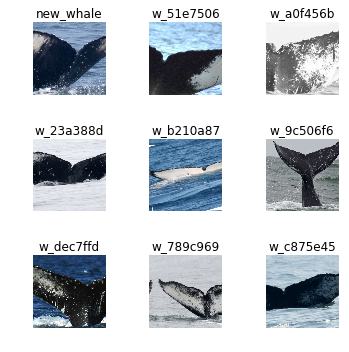

In [32]:
data0.show_batch(rows=3, figsize=(5,5))
#data.classes

#### Creating a pretrained Res-Net 18 model

In [34]:
learn = create_cnn(data0, models.resnet18, metrics=accuracy,pretrained=True)

#### Training our simple model

In [ ]:
learn.fit_one_cycle(1)

In [36]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,5.745871,4.930268,0.442209


In [19]:
learn.save('stage-a')

### Learning Rate finder allows us to find optimum value of learning rate. An optimum learning rate allows smoother training and also trains faster.

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


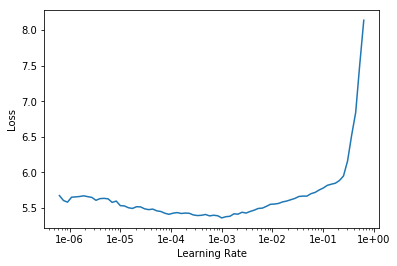

In [40]:
learn.recorder.plot()

### Training more based on new LR

In [41]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy
1,5.457494,4.742603,0.443921
2,5.150242,4.532394,0.457620


### Creating submission

In [24]:
# preds_t,y_t = learn.predict_with_targs(is_test=True) # Predicting without TTA
preds_t,y_t = learn.TTA(ds_type=data0.test_ds)
preds_t = np.stack(preds_t, axis=-1)
preds_t = np.exp(preds_t)
preds_t = preds_t.mean(axis=-1)


In [25]:
preds_t

array([1.469598, 1.000043, 1.000019, 1.000653, ..., 1.000143, 1.000026, 1.000038, 1.000018], dtype=float32)

In [26]:
sample=f'{path}/sample_submission.csv'
sample

'../../../../../.fastai/data/whale/sample_submission.csv'

In [27]:
test_names=os.listdir(f'{path}/test')

In [34]:
unique_labels = data0.classes

labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])

In [35]:
sample_df = pd.read_csv(sample)
sample_list = list(sample_df.Image)
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
pred_dic = dict((key, value) for (key, value) in zip(test_names,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv('submission.csv'.format(arch), header=True, index=False)
df.head()

KeyError: '00028a005.jpg'

### This submission gave us a LB score of  Private: 0.32075 and Public: 0.30136